In [55]:
import os
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Markdown, display

import numpy as np

from datasets import Dataset
from datasets import load_dataset

# Transformers module
from transformers import AutoTokenizer

# 1. Load the Dataset from Data Preparation document

In [ ]:
dataset = load_dataset("parquet", 
                        data_files = "./data/preprocessed_dataset.parquet", 
                        split="train")

print(f"Data type of the dataset object: {type(dataset)}")

# We will be applying sharding on huggingface dataset 
# Datasets that are Terabytes in size can be loaded and distributed parallely
dataset = dataset.shard(num_shards= 10, index = 0)

dataset[0:5]

Data type of the dataset object: <class 'datasets.arrow_dataset.Dataset'>


{'text': ['# Comparing the magnitudes of expressions of surds\n\nI recently tackled some questions on maths-challenge / maths-aptitude papers where the task was to order various expressions made up of surds (without a calculator, obviously).\n\nI found myself wondering whether I was relying too much on knowing the numerical value of some common surds, when a more robust method was available (and would work in more difficult cases).\n\nFor example, one question asked which is the largest of:\n\n(a) $\\sqrt{10}$\n(b) $\\sqrt2+\\sqrt3$\n(c) $5-\\sqrt3$\n\nIn this case, I relied on my knowledge that $\\sqrt{10} \\approx 3.16$ and $\\sqrt2\\approx 1.41$ and $\\sqrt3 \\approx 1.73$ to find (a) $\\approx 3.16$, (b) $\\approx ~3.14$ and (c) $\\approx ~3.27$ so that the required answer is (c).\n\nBut this seemed inelegant: I felt there might be some way to manipulate the surd expressions to make the ordering more explicit. I can\'t see what that might be, however (squaring all the expressions d

# 2. Tokenization

In [43]:
# We will be using wordpiece which resembles BPE (Bit Pair Encoding)
model_path_or_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(
                                        model_path_or_name,
                                        bos_token = "[BOS]", # Define the BOS token string
                                        eos_token = "[EOS]", # Define the EOS token string
                                        use_fast = True
                                    )
print(tokenizer._tokenizer.model)
print(f"BOS token ID: {tokenizer.bos_token_id}")
print(f"EOS token ID: {tokenizer.eos_token_id}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


BOS token ID: 30522
EOS token ID: 30523


### 2.1. Tokenization Helper function

In [46]:
def tokenize_text(sample):
    tokens = tokenizer.tokenize(sample["text"]) # Tokenizer using BPE appraoch
    token_ids = tokenizer.convert_tokens_to_ids(tokens)  

    # Appending BOS and EOS token ids
    input_ids = [tokenizer.bos_token_id] + token_ids + [tokenizer.eos_token_id]
    sample["input_ids"] = input_ids

    # Save the count of total number of token ids
    sample["num_tokens"] = len(input_ids)

    return sample 

dataset = dataset.map(tokenize_text)

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

In [54]:
print(f"Total number of tokens : {sum(dataset['num_tokens'])}")

print("Sample Text and their input ids:")
sample = dataset[-1]

print("text :",sample["text"][:30])
print("Input Ids: ", sample["input_ids"][:30])

Total number of tokens : 191939
Sample Text and their input ids:
text : # Find the value of point A an
Input Ids:  [30522, 1001, 2424, 1996, 3643, 1997, 2391, 1037, 1998, 1038, 1015, 1012, 13292, 2656, 1010, 2325, 1001, 1001, 1001, 18789, 14634, 1035, 2442, 2050, 7592, 8519, 1012, 1045, 2572, 22476]


# 3. Packing the data

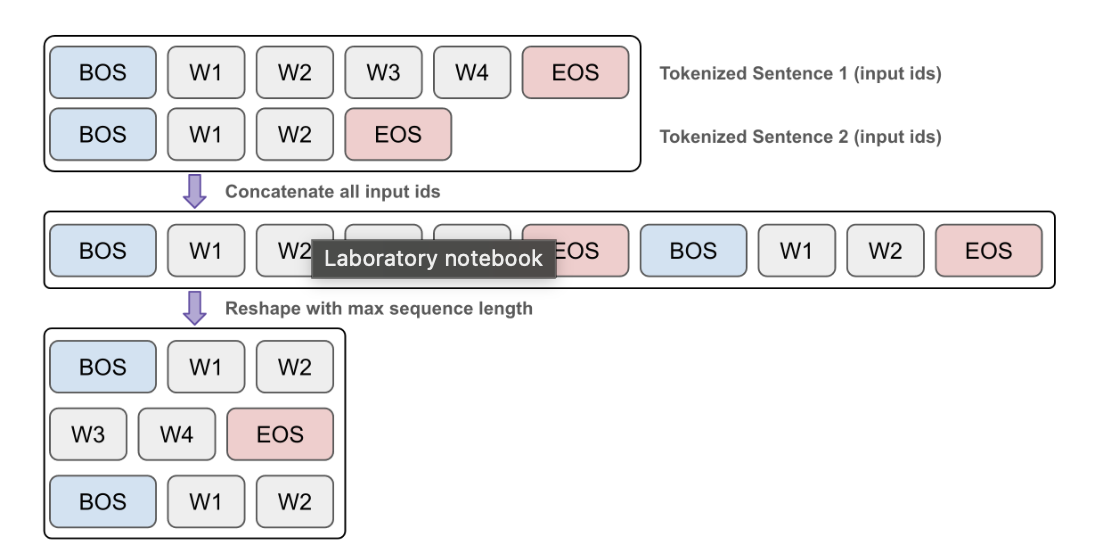

In [64]:
input_ids = np.concatenate(dataset["input_ids"])
print(f"length of input ids: {len(input_ids)}")

length of input ids: 191939


In [71]:
# let's set maximum length of each sample
max_seq_length  = 32
total_length_match_to_seq = len(input_ids) - (len(input_ids) % max_seq_length)

# Discard extra tokens from end of the list so number of tokens is exactly divisible by max_seq_length 
input_ids = input_ids[:total_length_match_to_seq]
print("length of the input ids:", len(input_ids))

length of the input ids: 191936


In [78]:
input_ids_reshaped = input_ids.reshape(-1, max_seq_length).astype(np.int32)
print(f"Shape of input ids : {input_ids_reshaped.shape}")

# Convert the input_ids into huggingface dataset
input_ids_dict = {"input_ids" : input_ids_reshaped.tolist()}
packaged_pretrain_dataset = Dataset.from_dict(input_ids_dict)
print("Type :", type(packaged_pretrain_dataset))

Shape of input ids : (5998, 32)
Type : <class 'datasets.arrow_dataset.Dataset'>


In [81]:
packaged_pretrain_dataset[0]

{'input_ids': [30522,
  1001,
  13599,
  1996,
  10194,
  2015,
  1997,
  11423,
  1997,
  7505,
  5104,
  1045,
  3728,
  26176,
  2070,
  3980,
  2006,
  8785,
  2015,
  1011,
  4119,
  1013,
  8785,
  2015,
  1011,
  26794,
  18679,
  4981,
  2073,
  1996,
  4708,
  2001]}

# 4. Saving packed dataset

In [83]:
filepath = "./data/packed_dataset.parquet"
packaged_pretrain_dataset.to_parquet(filepath)

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

791736

In [ ]:
""